# Evaluation of color terms when linking to PanSTARRS catalogs

Input is based on ODI quickreduce run on ODI calibration fields (typically 60s to 120s in g' r' i' z', 600 sec in u'). Quickreduce pairs instrumental aperture photometry from ODI image with reference catalog. Of interest here are the color terms only.


In [1]:
%matplotlib inline

import numpy as np                  # array manipulation
import astropy.io.fits as fits      # fits file manipulation
import matplotlib.pyplot as plt

plt.matplotlib.rcParams['figure.figsize'] = (8,6.0)

plt.gcf().autofmt_xdate()

np.set_printoptions(suppress=True)
np.set_printoptions(precision=5)

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 999;

<IPython.core.display.Javascript object>

Below, we are determine the color terms for the calibration from the ODI instrumental magnitudes to the reference system.
Caveats:
* PS1 catalog comes in PS1 intrinsic AB system. For a transformation to SDSS we use either Tony 2012 or Finkennbeiner 2016
* One can play with the order of the fit. second order seems to work fine ingerenal and seems to give somewhat consitent results between ODI-> SDSS vs. ODI -> SDSS <- PS1 calibration path
* One can also play with what the refence colro should be, depending on the SED of the objects. Here we choose g-i in the reference catalog system.

The calibration is overall noisy.

In [3]:
def ps2sdss (catalogdata):
    '''
    PS1 to SDSS conversion following Tonry et al 2012
    https://www.google.com/url?q=https%3A%2F%2Farxiv.org%2Fpdf%2F1203.0297.pdf&sa=D&sntz=1&usg=AFQjCNFZ3T88aqAPI32uYeygq7tNybjUHQ
    The field names of the PS1 magnitude colums are hardwired in here.
    The input catalog is overwritten, so make sure you do not need the original values any more!
    Correction only for griz filters!
    '''
    
    tonry = False
    
    # Tonry 2012
    ps1colorterms = {}
    
    if tonry:
        print "converting PS1 to sdss system via tonry"
        ps1colorterms['REF_G'] = [0.019, 0.145, 0.013]
        ps1colorterms['REF_R'] = [0.007, 0.004, -0.001]
        ps1colorterms['REF_I'] = [0.010, 0.011,-0.005]
        ps1colorterms['REF_Z'] = [-0.012, -0.039, 0.013]
        psgr = catalogdata['REF_G'] - catalogdata['REF_R']
    # Finkenbein 2016 
    # http://iopscience.iop.org/article/10.3847/0004-637X/822/2/66/meta#apj522061s2-4 Table 2
    else:
        print "converting PS1 to sdss system via finkenbeiner"
        ps1colorterms['REF_G'] = [-0.01808,-0.13595, 0.01941,-0.00183][::-1]
        ps1colorterms['REF_R'] = [-0.01836,-0.03577, 0.02612,-0.00558][::-1]
        ps1colorterms['REF_I'] = [ 0.01170,-0.00400, 0.00066,-0.00058][::-1]
        ps1colorterms['REF_Z'] = [-0.01062, 0.07529,-0.03592, 0.00890][::-1]
        psgr = catalogdata['REF_G'] - catalogdata['REF_I']

    for filter in ps1colorterms:
        colorcorrection = np.polyval (ps1colorterms[filter], psgr)
        if tonry:
            catalogdata[filter] += colorcorrection
        else:
             catalogdata[filter] -= colorcorrection
    
def processCatalog (file, refmagName, sdss=False):
    
    # readint the catalog

    f = fits.open (file)
    phottable = f['CAT.PHOTCALIB'].data

    if not sdss:
        
        ps2sdss (phottable)
   
    odimag = phottable['ODI_MAG_D30']
    odierr = phottable['ODI_ERR_D30']
    
    
    refErrName = refmagName.replace ("REF_", "REF_ERR_")
    refGName = 'REF_G'
    refRName = 'REF_I'
    refErrGName = 'REF_ERR_G'
    refErrRName = 'REF_ERR_I'
    
    #print refmagName,refErrName,refGName,refErrGName,refRName,refErrRName
    if (sdss):
        # different naming convention between sdss and ps1 catalogs
        refmagName = refmagName.replace ("REF_", "SDSS_MAG_")
        refErrName = refErrName.replace ("REF_ERR", "SDSS_ERR")
        refGName = refGName.replace ("REF_", "SDSS_MAG_")
        refRName = refRName.replace ("REF_", "SDSS_MAG_")
        refErrGName = refErrGName.replace ("REF_ERR", "SDSS_ERR")
        refErrRName = refErrRName.replace ("REF_ERR", "SDSS_ERR")
        #print refmagName,refErrName,refGName,refErrGName,refRName,refErrRName
                                           
    refmag = phottable[refmagName]
    referr = phottable[refErrName]   
    refcol = phottable[refGName] - phottable[refRName]

    deltamag = odimag - refmag

    deltaerr = np.sqrt (np.square (referr) + np.square (odierr) + np.square (phottable[refErrGName]) + np.square (phottable[refErrRName]))

    smallerror = deltaerr < 0.075

    
    # do the color fit
    fig = plt.figure()
    plt.plot (refcol, deltamag, ".", color='orange')
    _x = refcol[smallerror]
    _y = deltamag[smallerror]
    plt.plot (_x, _y, ".", color='green')

    # polynomial order of the fit:
    order = 2
    
    # fit with 0.5 mag outlier rejection
    fit = np.polyfit (_x, _y,order)
    fiterror = np.abs (_y - np.polyval (fit, _x))
    fit = np.polyfit (_x[fiterror <0.2], _y[fiterror < 0.2], order)
    
    plt.plot (_x[fiterror <0.2], _y[fiterror < 0.2], ".", color='magenta')
    _fx = np.arange(-1,3.5, 0.2)
    _fy = np.polyval (fit, _fx)
    plt.plot ( _fx,_fy)
    
    plt.title ("Color term fit")
    plt.xlabel (" (g - i)_{ref}")
    plt.ylabel ("ODIMAG - %s" % refmagName)
    plt.ylim ([fit[-1]-0.5,fit[-1]+0.5])
    plt.grid()
    # make a color corrected refmag-ZP plot
    fig = plt.figure ()
   
    correction = np.polyval (fit,refcol)
    residual = deltamag[smallerror] - correction[smallerror]
   
    std = np.std (residual)
    plt.plot (refmag[smallerror], residual, ".")
    
    plt.xlabel ("%s" % refmagName)
    plt.ylabel ("ODIMAG - %s - colorterm" % (refmagName))
    plt.title ("Color corrected %s stddev: %4.2f" % (fit [::-1], std))
    plt.ylim ([-0.2,0.2])
    plt.grid ()
    
    print refmagName, fit, ("variance: %4.2f"%std)



converting PS1 to sdss system via finkenbeiner
REF_G [ -0.03096   0.10251 -31.25143] variance: 0.11
converting PS1 to sdss system via finkenbeiner
REF_R [  0.0043   -0.00737 -31.22964] variance: 0.13
converting PS1 to sdss system via finkenbeiner
REF_I [ -0.00108  -0.00069 -30.84467] variance: 0.10
converting PS1 to sdss system via finkenbeiner
REF_Z [ -0.008     0.03231 -29.98807] variance: 0.11


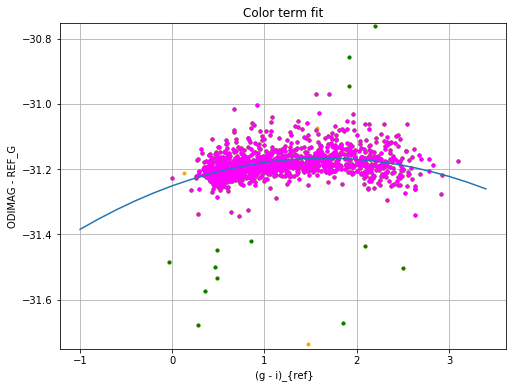

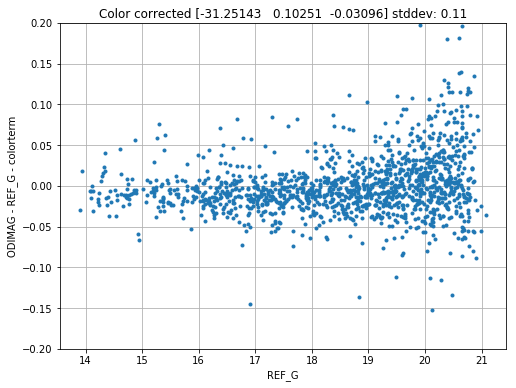

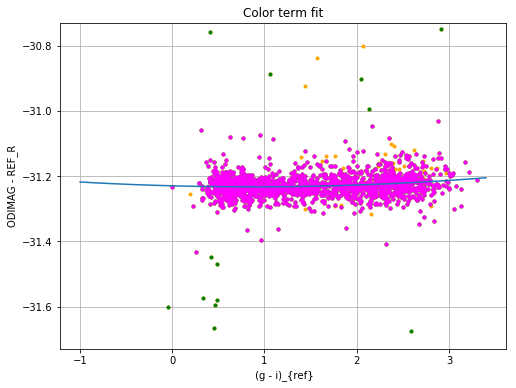

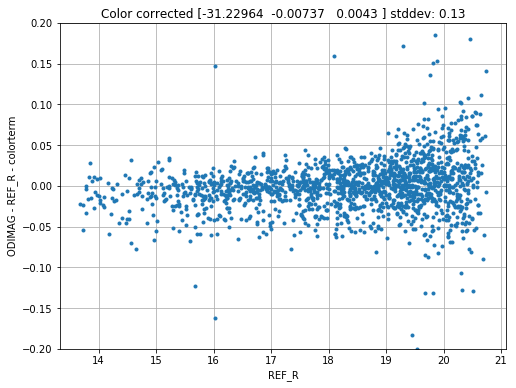

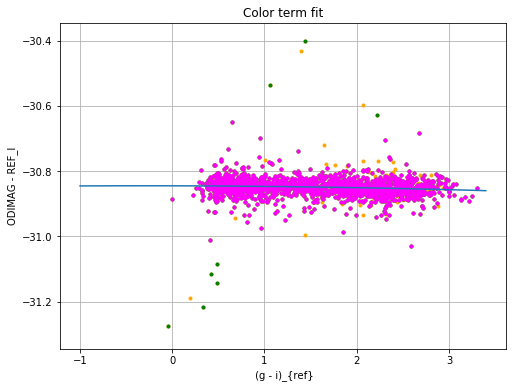

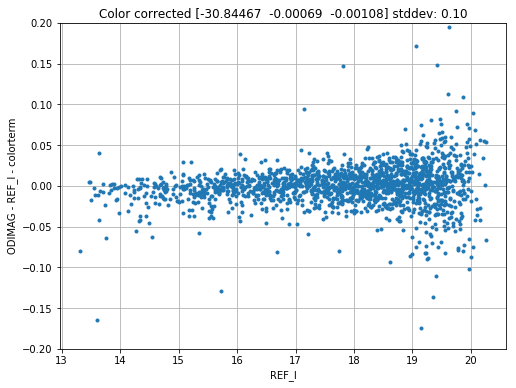

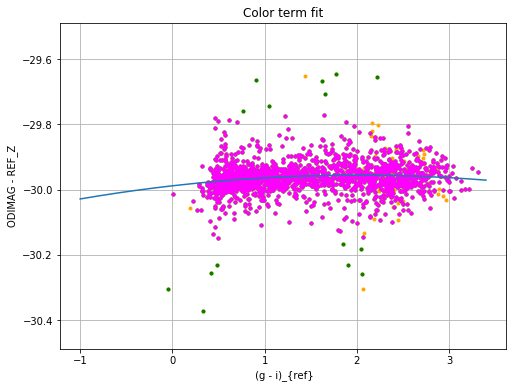

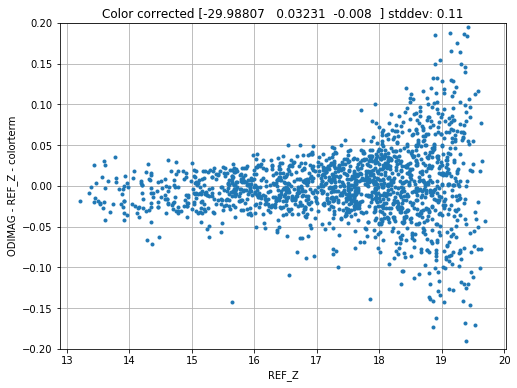

In [4]:
processCatalog ("/home/harbeck/ODI/iraf/psphot/ps1/20170131T033657.1.fits", 'REF_G')
processCatalog ("/home/harbeck/ODI/iraf/psphot/ps1/20170131T033023.1.fits", 'REF_R')
processCatalog ("/home/harbeck/ODI/iraf/psphot/ps1/20170131T033350.1.fits", 'REF_I')
processCatalog ("/home/harbeck/ODI/iraf/psphot/ps1/20170131T034008.1.fits", 'REF_Z')

SDSS_MAG_G [ -0.0143    0.04944 -31.18804] variance: 0.10
SDSS_MAG_R [  0.00047  -0.00283 -31.18932] variance: 0.14
SDSS_MAG_I [ -0.01074   0.02875 -30.84816] variance: 0.17
SDSS_MAG_Z [ -0.0208    0.07157 -29.98845] variance: 0.11


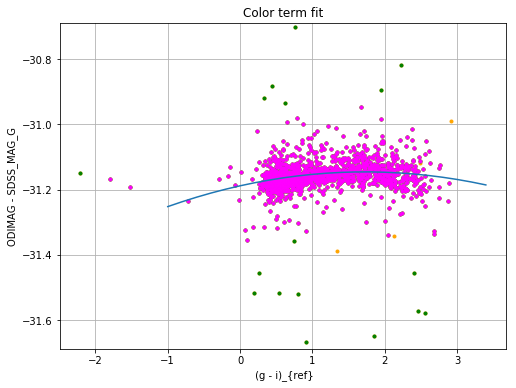

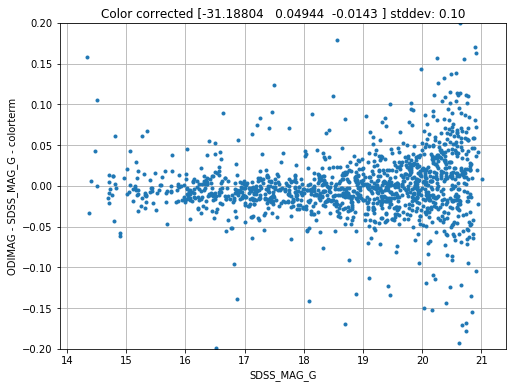

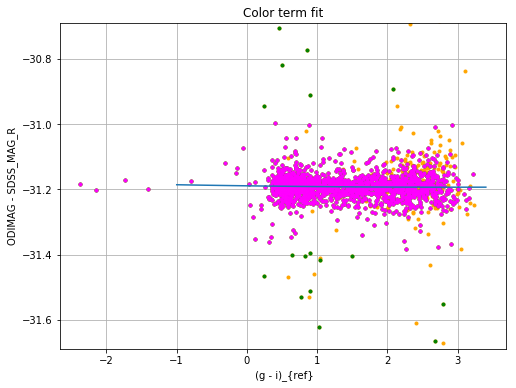

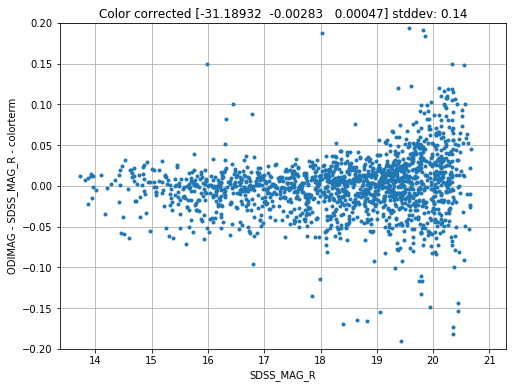

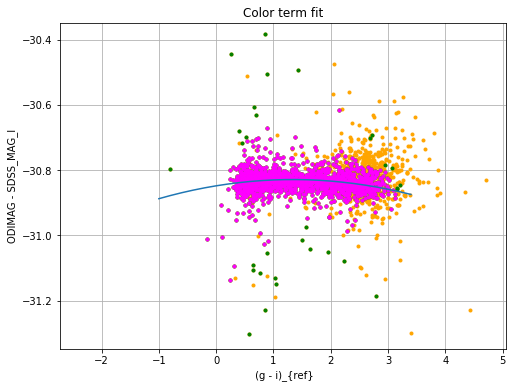

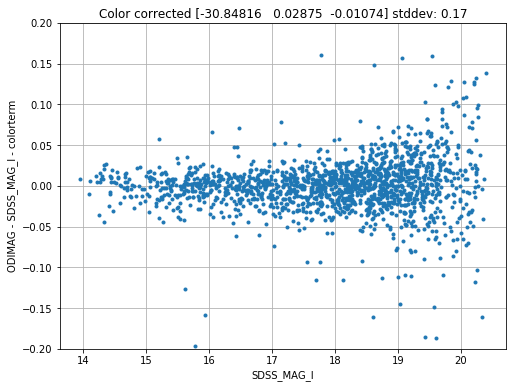

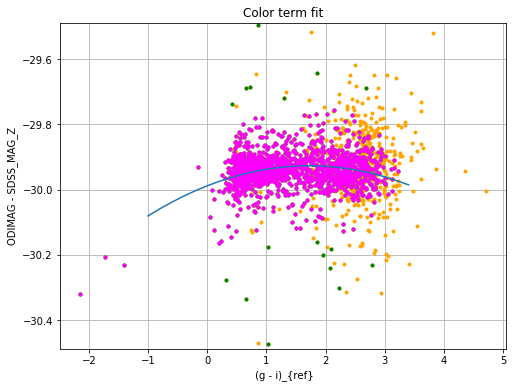

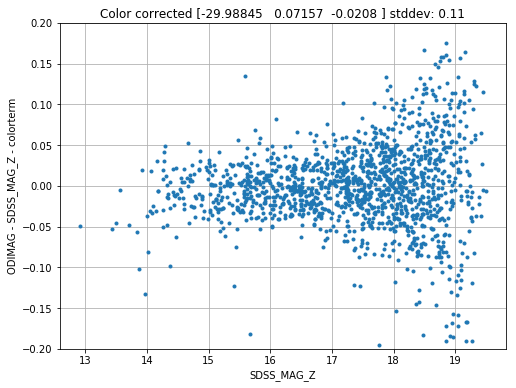

In [5]:
processCatalog ("/home/harbeck/ODI/iraf/psphot/sdss/20170131T033657.1.fits", 'REF_G', True)
processCatalog ("/home/harbeck/ODI/iraf/psphot/sdss/20170131T033023.1.fits", 'REF_R', True)
processCatalog ("/home/harbeck/ODI/iraf/psphot/sdss/20170131T033350.1.fits", 'REF_I', True)
processCatalog ("/home/harbeck/ODI/iraf/psphot/sdss/20170131T034008.1.fits", 'REF_Z', True)

#Summary findings:



~~~~ 
Based on g-i

quadratic
SDSS
SDSS_MAG_G [ -0.0143    0.04944 -31.18804] variance: 0.10
SDSS_MAG_R [  0.00047  -0.00283 -31.18932] variance: 0.14
SDSS_MAG_I [ -0.01074   0.02875 -30.84816] variance: 0.17
SDSS_MAG_Z [ -0.0208    0.07157 -29.98845] variance: 0.11

PS1
converting PS1 to sdss system via finkenbeiner
REF_G [ -0.03096   0.10251 -31.25143] variance: 0.11
REF_R [  0.0043   -0.00737 -31.22964] variance: 0.13
REF_I [ -0.00108  -0.00069 -30.84467] variance: 0.10
REF_Z [ -0.008     0.03231 -29.98807] variance: 0.11

PS1 raw
no prior converion to SDSS
REF_G [ -0.04948   0.23765 -31.22674] variance: 0.11
REF_R [  0.00348  -0.00306 -31.20088] variance: 0.13
REF_I [  0.00073  -0.00045 -30.85514] variance: 0.10
~~~~ 